In [1]:
import pandas as pd
import matplotlib.pyplot as plt


data_path = r"D:\AQI_Forecasting\backend\data\bangkok-air-quality_update.csv"
df = pd.read_csv(data_path)
df


,date,pm25,pm10,o3,no2,so2,co
0,2025/2/1,157,59,20,1,,
1,2025/2/2,150,63,25,3,,
2,2025/2/3,139,53,18,1,,
3,2025/2/4,122,63,19,1,,
4,2025/2/5,134,56,22,2,,
...,...,...,...,...,...,...,...
4048,2015/3/15,,,23,13,3,9
4049,2014/11/30,,,40,36,4,11
4050,2013/12/31,,,68,33,3,7
4051,2014/1/26,,,54,53,6,18


In [2]:
import pandas as pd
import numpy as np
import aqi


def remove_whitespace_cols(df):
    df.columns = df.columns.str.strip()
    return df

def cleaning_data(df):
    df = remove_whitespace_cols(df)
    if 'date' not in df.columns:
        raise ValueError('date column not found')
    else:
        
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    for col in df.columns:
        if col != 'date':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.sort_values('date').reset_index(drop=True)
    return df

def calc_aqi(row: pd.Series):
    pollutants = {
        'pm25': aqi.POLLUTANT_PM25,
        'pm10': aqi.POLLUTANT_PM10,
        'o3': aqi.POLLUTANT_O3_8H,
        'no2': aqi.POLLUTANT_NO2_1H,
        'so2': aqi.POLLUTANT_SO2_1H,
        'co': aqi.POLLUTANT_CO_8H
    }
    aqi_values = []
    for pollutant, aqi_pollutant in pollutants.items():
        if pollutant in row and pd.notna(row[pollutant]):
            try:
                aqi_values.append(aqi.to_aqi([(aqi_pollutant, row[pollutant])]))
            except TypeError:
                continue
    if len(aqi_values) == 0:
        return np.nan
    return np.max(aqi_values)

def preprocess_data(df):
    
    if 'date' not in df.columns or 'aqi' not in df.columns:
        raise ValueError('Required columns not found')
    aqi_df = df[['date', 'aqi']].copy()
    aqi_df['aqi'] = pd.to_numeric(aqi_df['aqi'], errors='coerce')
    aqi_df.set_index('date', inplace=True)
    
    aqi_df['aqi'] = aqi_df['aqi'].interpolate(method='time')
    return aqi_df

def load_and_clean_data(data_path):
    df = pd.read_csv(data_path)
    df_clean = cleaning_data(df)
    df_clean['aqi'] = df_clean.apply(calc_aqi, axis=1)
    aqi_df = preprocess_data(df_clean)
    return aqi_df

In [3]:
aqi_df = load_and_clean_data(data_path)
aqi_df

,aqi
date,
2013-12-31,76.0
2014-01-01,204.0
2014-01-02,176.0
2014-01-03,159.0
2014-01-04,74.0
...,...
2025-02-07,184.0
2025-02-08,182.0
2025-02-09,167.0


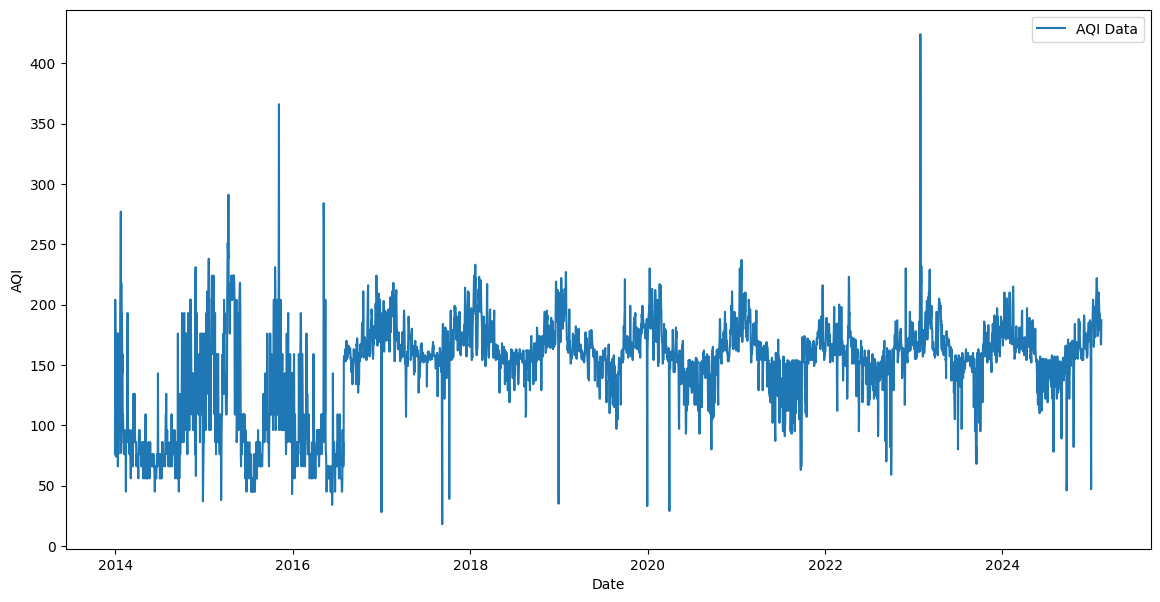

In [4]:
try:
    plt.figure(figsize=(14, 7))
    plt.plot(aqi_df["aqi"], label="AQI Data")
    
    # Labels and legend
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.legend()
    
    # Show plot
    plt.show()
except Exception as e:
    print("Can't plot. The data is empty!")

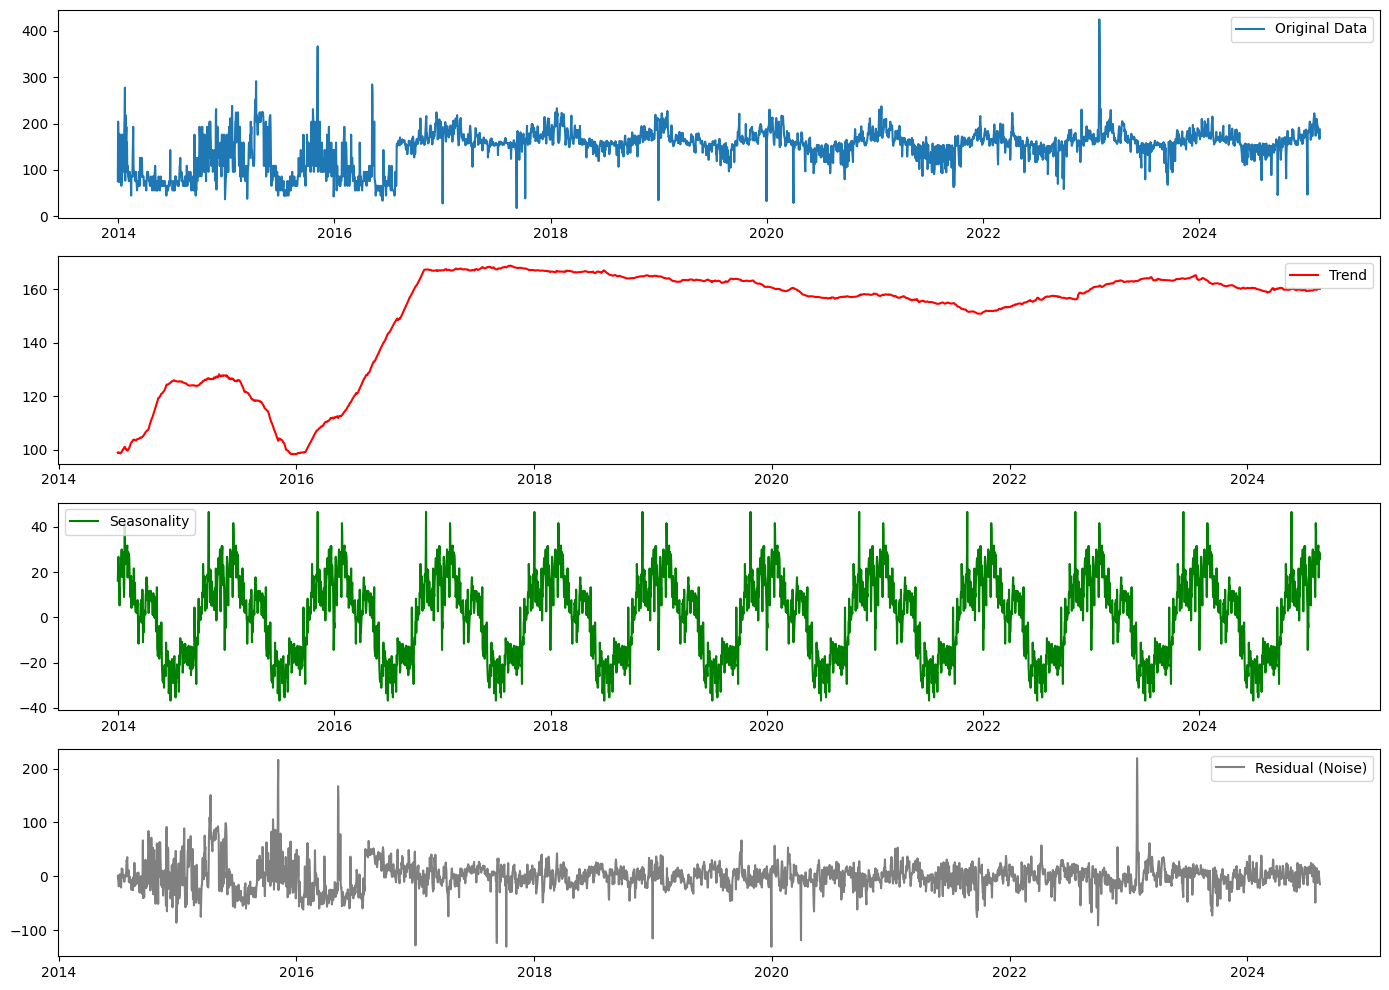

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(aqi_df['aqi'], model="additive", period=365)
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(aqi_df['aqi'], label="Original Data")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonality", color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual (Noise)", color='gray')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
import pmdarima as pm
smodel = pm.auto_arima(aqi_df,start_p=1,start_q=1,
                       test='adf',
                       max_p=3,max_q=3,m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
smodel.summary()

d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_for

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=40003.412, Time=0.14 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=37122.936, Time=2.37 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=37145.350, Time=3.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=40001.480, Time=0.10 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=38375.458, Time=0.29 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=36789.215, Time=10.28 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=19.82 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.42 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=38762.470, Time=6.09 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=36778.738, Time=9.29 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=37120.754, Time=3.53 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.91 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.99 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=36754.720, Time=11.69 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=37111.047, Time=4.80 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=23.74 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=10.30 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=36718.015, Time=23.07 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,1,0)[12] intercept   : AIC=37093.457, Time=11.99 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=42.69 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=17.53 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=36721.692, Time=23.00 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,1,0)[12] intercept   : AIC=36618.074, Time=40.25 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=17.41 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,1,1)[12] intercept   : AIC=inf, Time=45.78 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=20.36 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=36718.459, Time=13.15 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(2,1,0)[12] intercept   : AIC=36722.256, Time=42.35 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(2,1,0)[12] intercept   : AIC=36719.684, Time=36.36 sec


d:\AQI_forecasting\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,1,0)[12]             : AIC=inf, Time=14.93 sec

Best model:  ARIMA(3,0,2)(2,1,0)[12] intercept
Total fit time: 499.520 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 4053
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood              -18300.037
Date:                             Tue, 18 Feb 2025   AIC                          36618.074
Time:                                     12:35:00   BIC                          36674.812
Sample:                                          0   HQIC                         36638.175
                                            - 4053                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1272      0.096     -1.320      0.187      -0.316       0.062
ar.L1          2.2856      0.009    261.108      0.000       2.268       2.303
ar.L2         -1.9638      0.015   -127.744      0.000      -1.994      -1.934
ar.L3          0.5957      0.008     74.142      0.000       0.580       0.611
ma.L1         -1.7058      0.006   -274.906      0.000      -1.718      -1.694
ma.L2          0.9712      0.006    155.485      0.000       0.959       0.983
ar.S.L12      -0.6440      0.010    -65.996      0.000      -0.663      -0.625
ar.S.L24      -0.2829      0.009    -30.641      0.000      -0.301      -0.265
sigma2       502.3189      4.359    115.240      0.000     493.776     510.862
===================================================================================
Ljung-Box (L1) (Q):                   4.40   Jarque-Bera (JB):             25905.66
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""